In [335]:
%pylab inline
indir = '/mnt/store1/oliverphilcox/3PCF_QPM/3PCFCovMatricesAll/'#3PCF_QPM_v3/3PCFCovMatricesAll/'
n=15
l=6
m=l+1

Populating the interactive namespace from numpy and matplotlib


In [336]:
def symmetrize(mat):
    """ Add in symmetries to matrices """
    out_mat = np.zeros_like(mat)
    for i in range(len(mat)//m):
        a = i//n
        b = i%n
        for j in range(len(mat)//m):
            c = j//n
            d = j%n
            # Add to all relevant bins
            these_mat = mat[i*m:(i+1)*m,j*m:(j+1)*m]*0.25
            out_mat[(a*n+b)*m:(a*n+b)*m+m,(c*n+d)*m:(c*n+d)*m+m]+=these_mat
            out_mat[(b*n+a)*m:(b*n+a)*m+m,(c*n+d)*m:(c*n+d)*m+m]+=these_mat
            out_mat[(b*n+a)*m:(b*n+a)*m+m,(d*n+c)*m:(d*n+c)*m+m]+=these_mat
            out_mat[(a*n+b)*m:(a*n+b)*m+m,(d*n+c)*m:(d*n+c)*m+m]+=these_mat
    return 0.5*(out_mat+out_mat.T)

In [337]:
def plotter(mat,vmax=np.inf,perc=99,rmax=0):
    if vmax==np.inf:
        vmax=np.percentile(mat,perc)
    plt.matshow(mat,vmax=vmax,vmin=-vmax,cmap=cm.RdBu_r);
    plt.colorbar();
    if rmax==0:
        rmax = len(mat)
    plt.ylim([-0.5,rmax-0.5])
    plt.xlim([-0.5,rmax-0.5])

In [338]:
def rebinner(mat):
    out_mat = np.zeros_like(mat)
    for i in range(m):
        for j in range(m):
            out_mat[i*n*n:(i+1)*n*n,j*n*n:(j+1)*n*n]=mat[i::m,j::m]
    return out_mat

In [339]:
total_counts = np.loadtxt(indir+'total_counts_n%d_l%d_0.txt'%(n,l))

In [340]:
print("Triples: %.1e Quads: %.1e, Quints: %.1e, Hexes: %.1e"%(total_counts[0],total_counts[1],total_counts[2],total_counts[3]))

Triples: 1.2e+09 Quads: 3.5e+09, Quints: 1.4e+10, Hexes: 5.5e+10


In [341]:
bins_r = np.loadtxt('/mnt/store1/oliverphilcox/3PCF/SE_binning_n15.csv')

In [342]:
print('Radial Bins')
print(bins_r[:,0])
print(bins_r[:,1])
delta_r = bins_r[-1,0]-bins_r[-2,0]

Radial Bins
[ 30.  40.  50.  60.  70.  80.  90. 100. 110. 120. 130. 140. 150. 160.
 170.]
[ 40.  50.  60.  70.  80.  90. 100. 110. 120. 130. 140. 150. 160. 170.
 180.]


In [343]:
c30=np.loadtxt(indir+'c3_n%d_l%d_0_full.txt'%(n,l))
c40=np.loadtxt(indir+'c4_n%d_l%d_0_full.txt'%(n,l))
c50=np.loadtxt(indir+'c5_n%d_l%d_0_full.txt'%(n,l))
c60=np.loadtxt(indir+'c6_n%d_l%d_0_full.txt'%(n,l))
c31=np.loadtxt(indir+'c3_n%d_l%d_1_full.txt'%(n,l))
c41=np.loadtxt(indir+'c4_n%d_l%d_1_full.txt'%(n,l))
c51=np.loadtxt(indir+'c5_n%d_l%d_1_full.txt'%(n,l))
c61=np.loadtxt(indir+'c6_n%d_l%d_1_full.txt'%(n,l))
c3=c30+c31
c4=c40+c41
c5=c50+c51
c6=c60+c61

In [344]:
np.savez(indir+'../simple_output.npz',c30=c30,c31=c31,
        c40=c40,c41=c41,c50=c50,c51=c51,c60=c60,c61=c61,n_runs=1,tot0 = total_counts)

In [345]:
c3s=symmetrize(c3)
c4s=symmetrize(c4)
c5s=symmetrize(c5)
c6s=symmetrize(c6)

## Use SE compression

In [346]:
good_r_bins=[]
for b1 in range(n):
    for b2 in range(n):
        r1=bins_r[b1,0]
        r2=bins_r[b2,0]
        if (r2>=3*delta_r) and (r2<r1-3*delta_r):
            good_r_bins.append(b1)
good_r_bins = np.unique(np.asarray(good_r_bins))
n_g = len(good_r_bins)
min_r_bin = min(good_r_bins)

In [347]:
def reduce(mat):
    out_mat = np.zeros_like(mat)
    for i in range(len(mat)):
        for j in range(len(mat)):
            out_mat[i,j]=mat[i,j]/np.sqrt(mat[i,i]*mat[j,j])
    return out_mat

In [348]:
def compression(mat):
    comp_mat = np.zeros([n_g*m,n_g*m])
    den = np.zeros([n_g*m,n_g*m])

    all_v = 4.*np.pi*(bins_r[:,1]**3-bins_r[:,0]**3)/3

    for i in range(len(mat)):
        l = i%m
        b1 = (i//m)//n
        r1 = bins_r[b1,0]
        if b1<min_r_bin:
            continue
        b2 = (i//m)%n
        r2 = bins_r[b2,0]
        if (r2>=3*delta_r) and (r2<r1-3*delta_r):
            v_b2 = all_v[b2]

            for j in range(len(mat)):
                l2 = j%m
                b3 = (j//m)//n
                r3 = bins_r[b3,0]
                if b3<min_r_bin:
                    continue
                b4 = (j//m)%n
                r4 = bins_r[b4,0]
                if (r4>=3*delta_r) and (r4<r3-3*delta_r):
                    v_b4 = all_v[b4]

                    comp_mat[l*n_g+b1-min_r_bin,l2*n_g+b3-min_r_bin]+=mat[i,j]*v_b2*v_b4
                    den[l*n_g+b1-min_r_bin,l2*n_g+b3-min_r_bin]+=v_b2*v_b4

    comp_mat/=den
    return comp_mat

In [349]:
c3se=compression(c3s)
c4se=compression(c4s)
c5se=compression(c5s)
c6se=compression(c6s)

In [350]:
c60se=compression(symmetrize(c60))

## Compute N_eff

In [351]:
alpha=1.
max_file=20
this_ctot=[]

for i in range(max_file):
    print('Loading components %d of %d'%(i+1,max_file))
    
    c30t=np.loadtxt(indir+'c3_n%d_l%d_0_%d.txt'%(n,l,i))
    c31t=np.loadtxt(indir+'c3_n%d_l%d_1_%d.txt'%(n,l,i))
    c40t=np.loadtxt(indir+'c4_n%d_l%d_0_%d.txt'%(n,l,i))
    c41t=np.loadtxt(indir+'c4_n%d_l%d_1_%d.txt'%(n,l,i))
    c50t=np.loadtxt(indir+'c5_n%d_l%d_0_%d.txt'%(n,l,i))
    c51t=np.loadtxt(indir+'c5_n%d_l%d_1_%d.txt'%(n,l,i))
    c60t=np.loadtxt(indir+'c6_n%d_l%d_0_%d.txt'%(n,l,i))
    c61t=np.loadtxt(indir+'c6_n%d_l%d_1_%d.txt'%(n,l,i))
    
    c3t=c30t+c31t
    c4t=c40t+c41t
    c5t=c50t+c51t
    c6t=c60t+c61t
    
    c3st=symmetrize(c3t)
    c4st=symmetrize(c4t)
    c5st=symmetrize(c5t)
    c6st=symmetrize(c6t)

    c3set=compression(c3st)
    c4set=compression(c4st)
    c5set=compression(c5st)
    c6set=compression(c6st)
    
    this_ctot.append(c6set+c5set*alpha+c4set*alpha**2+c3set*alpha**3)

Loading components 1 of 20


KeyboardInterrupt: 

In [353]:
this_ctot = np.asarray(this_ctot)
max_bin = 77
summ=0.

for i in range(max_file):
    this_cov = this_ctot[i][:max_bin,:max_bin]
    other_cov = np.mean(np.asarray(list(this_ctot[:i])+list(this_ctot[i+1:])),axis=0)[:max_bin,:max_bin]
    summ+=np.matmul(np.linalg.inv(other_cov),this_cov)
    
D_matrix = (max_file-1.)/(max_file)*(-np.identity(len(this_cov))+summ/max_file)

slogdetD = np.linalg.slogdet(D_matrix)

n_eff = (len(this_cov)+1.)/np.exp(slogdetD[1]/len(this_cov))+1.

print("n_eff = %.2e"%n_eff)

IndexError: index 0 is out of bounds for axis 0 with size 0

In [354]:
np.savez(indir+'../compressed_qpm_theory.npz',c3=c3se,c4=c4se,c5=c5se,c6=c6se,n_eff=n_eff,c60=c60se)

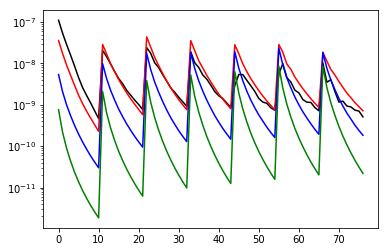

In [297]:
plt.plot(np.diag(c6se),c='k')
plt.plot(np.diag(c5se),c='r')
plt.plot(np.diag(c4se),c='b')
plt.plot(np.diag(c3se),c='g')
plt.yscale('log');

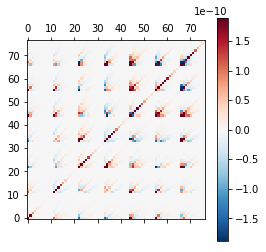

In [279]:
plotter(c3se)

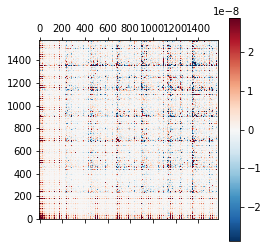

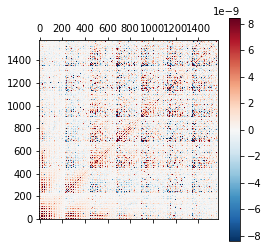

In [220]:
plotter(rebinner(symmetrize(c60)))
plotter(rebinner(symmetrize(c61)))

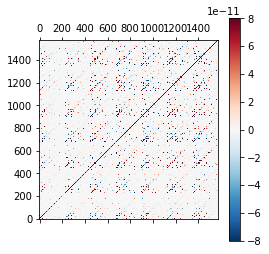

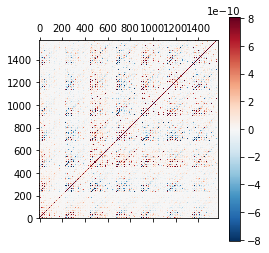

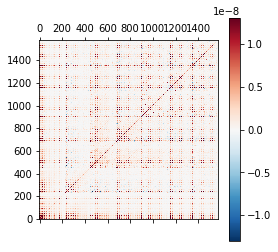

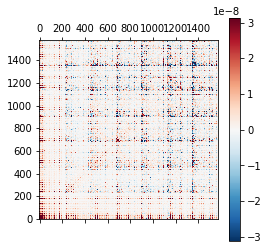

In [221]:
plotter(rebinner(c3s))
plotter(rebinner(c4s))
plotter(rebinner(c5s))
plotter(rebinner(c6s))

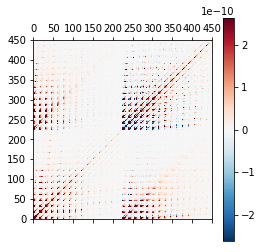

In [121]:
plotter(rebinner(c4s))

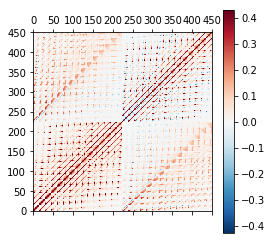

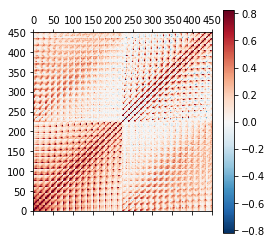

In [122]:
plotter(reduce(rebinner(c4s)))
plotter(reduce(rebinner(c5s)))

## Reduced Theory Covariance Matrix

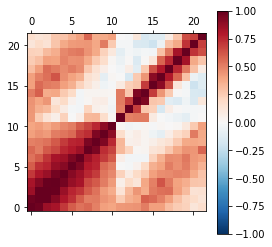

In [123]:
plotter(reduce(c6se+c5se+c4se+c3se))

## Full Theory Covariance Matrix

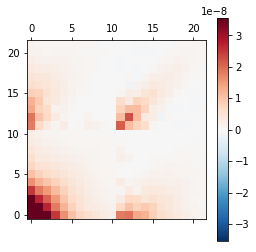

In [124]:
plotter(c6se+c5se+c4se+c3se)

**Difference between two C3 estimates**~

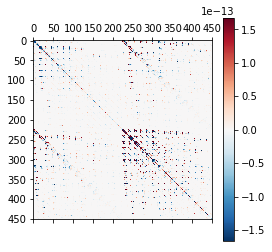

In [125]:
mat=rebinner(symmetrize(c30-c31))
vmax=np.percentile(rebinner(symmetrize(c30)),90.)
plt.matshow(mat,vmax=vmax,vmin=-vmax,cmap=cm.RdBu_r);
plt.colorbar();

In [126]:
tot_mat = symmetrize(c3+c4+c5+c6)

## Total Matrix

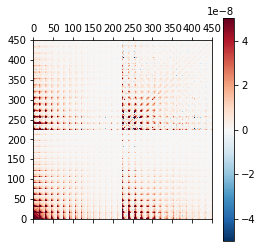

<Figure size 432x288 with 0 Axes>

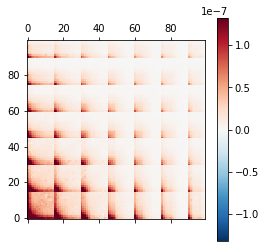

In [127]:
plotter(rebinner(symmetrize(tot_mat)))
plt.figure()
plotter(rebinner(symmetrize(tot_mat))[:100,:100])

In [128]:
b30=np.loadtxt(indir+'binct_c3_n%d_l%d_0_full.txt'%(n,l))
b40=np.loadtxt(indir+'binct_c4_n%d_l%d_0_full.txt'%(n,l))
b50=np.loadtxt(indir+'binct_c4_n%d_l%d_0_full.txt'%(n,l))
b60=np.loadtxt(indir+'binct_c4_n%d_l%d_0_full.txt'%(n,l))
b31=np.loadtxt(indir+'binct_c4_n%d_l%d_0_full.txt'%(n,l))
b41=np.loadtxt(indir+'binct_c4_n%d_l%d_0_full.txt'%(n,l))
b51=np.loadtxt(indir+'binct_c5_n%d_l%d_0_full.txt'%(n,l))
b61=np.loadtxt(indir+'binct_c6_n%d_l%d_0_full.txt'%(n,l))

**6-point Sampling**

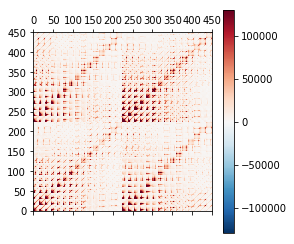

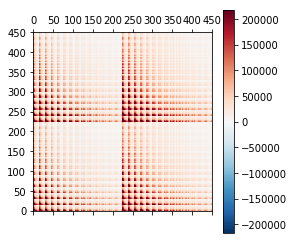

In [129]:
plotter(rebinner(symmetrize(b60)))
plotter(rebinner(symmetrize(b61)))

**3 Point**

(0, 300)

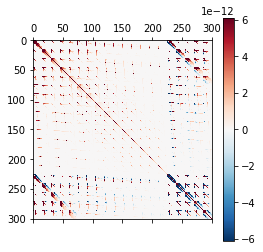

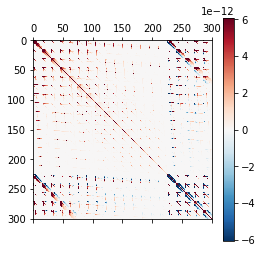

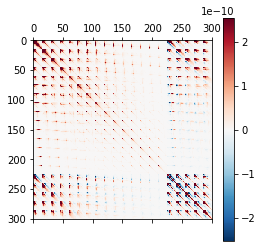

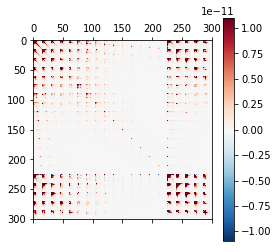

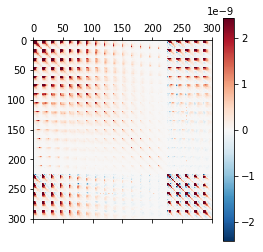

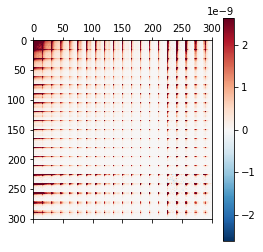

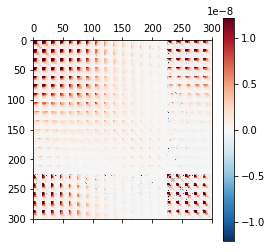

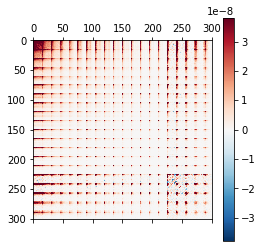

In [130]:
plotter(rebinner(symmetrize(c31)));plt.ylim([300,0]);plt.xlim([0,300])
plotter(rebinner(symmetrize(c30)));plt.ylim([300,0]);plt.xlim([0,300])
plotter(rebinner(symmetrize(c41)));plt.ylim([300,0]);plt.xlim([0,300])
plotter(rebinner(symmetrize(c40)));plt.ylim([300,0]);plt.xlim([0,300])
plotter(rebinner(symmetrize(c51)));plt.ylim([300,0]);plt.xlim([0,300])
plotter(rebinner(symmetrize(c50)));plt.ylim([300,0]);plt.xlim([0,300])
plotter(rebinner(symmetrize(c61)));plt.ylim([300,0]);plt.xlim([0,300])
plotter(rebinner(symmetrize(c60)));plt.ylim([300,0]);plt.xlim([0,300])

In [56]:
def collapse_axes(mat,c_bin,d_bin):
    new_mat = np.zeros([m,m,n,n])
    for i in range(len(mat)):
        p_bin = i%m
        a_bin = (i//m)//n
        b_bin = (i//m)%n
        for q_bin in range(m):
            new_mat[p_bin,q_bin,a_bin,b_bin] = mat[i,c_bin*n+d_bin*m+q_bin]
    return new_mat

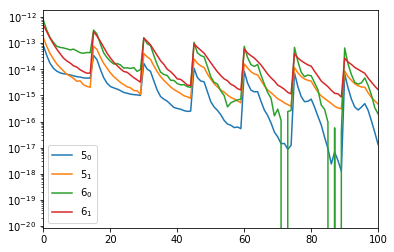

In [57]:
plt.plot(np.diag(rebinner(symmetrize(c50)))[:n*n],label=r'$5_0$')
plt.plot(np.diag(rebinner(symmetrize(c51)))[:n*n],label=r'$5_1$')
plt.plot(np.diag(rebinner(symmetrize(c60)))[:n*n],label=r'$6_0$')
plt.plot(np.diag(rebinner(symmetrize(c61)))[:n*n],label=r'$6_1$')
plt.legend();plt.xlim([0,100])
plt.yscale('log');

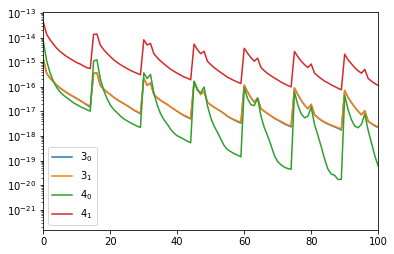

In [58]:
plt.plot(np.diag(rebinner(symmetrize(c30)))[:n*n],label=r'$3_0$')
plt.plot(np.diag(rebinner(symmetrize(c31)))[:n*n],label=r'$3_1$')
plt.plot(np.diag(rebinner(symmetrize(c40)))[:n*n],label=r'$4_0$')
plt.plot(np.diag(rebinner(symmetrize(c41)))[:n*n],label=r'$4_1$')
plt.legend();plt.xlim([0,100])
plt.yscale('log');

In [59]:
def variance(mat):
    out_mat = np.zeros([m,n,n])
    for p in range(m):
        for i in range(n):
            for j in range(n):
                out_mat[p,i,j]=mat[(i*n+j)*m+p,(i*n+j)*m+p]
    return out_mat

In [60]:
collapsed_mat = collapse_axes(tot_mat,5,7)
collapsed_mat.shape

(5, 5, 15, 15)

In [61]:
def collapse_axes_all_corr(mat,c_bin,d_bin):
    new_mat = np.zeros([n*m,n*m])
    for i in range(len(mat)):
        p_bin = i%m
        a_bin = (i//m)//n
        b_bin = (i//m)%n
        for q_bin in range(m):
            new_mat[p_bin*n+a_bin,q_bin*n+b_bin] += mat[i,c_bin*n*m+d_bin*m+q_bin]
    # Now compute correlation matrix
    corr_mat = np.zeros([n*m,n*m])
    for i in range(len(corr_mat)):
        p_bin = i//n
        a_bin = i%n
        for j in range(len(corr_mat[0])):
            q_bin = j//n
            b_bin = j%n
            corr_mat[p_bin*n+a_bin,q_bin*n+b_bin]=new_mat[p_bin*n+a_bin,q_bin*n+b_bin]/np.sqrt(new_mat[p_bin*n+a_bin,q_bin*n+a_bin]*new_mat[p_bin*n+b_bin,q_bin*n+b_bin])
    return corr_mat

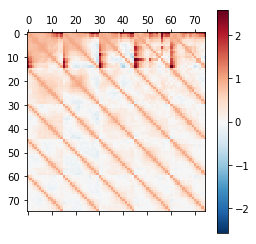

In [62]:
collapsed_mat = collapse_axes_all_corr(tot_mat,5,7)
vmax=np.percentile(collapsed_mat,99.9)
plt.matshow(collapsed_mat,vmax=vmax,vmin=-vmax,cmap=cm.RdBu_r);
#plt.title(r'$C_{%d%d}$'%(2*i,2*j))
plt.colorbar();

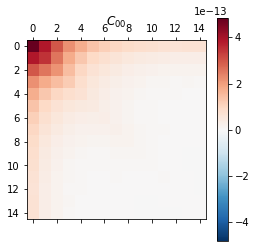

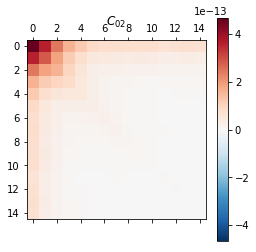

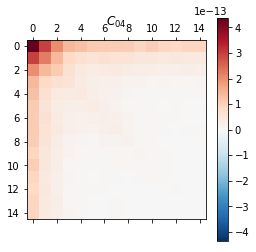

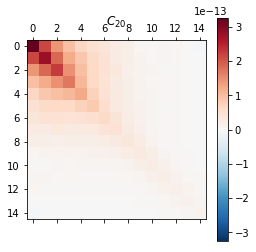

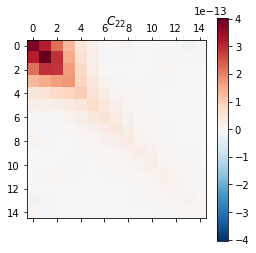

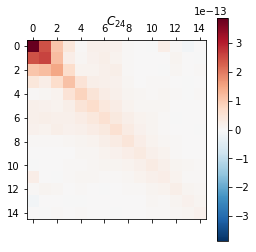

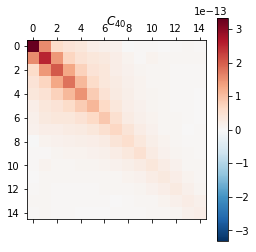

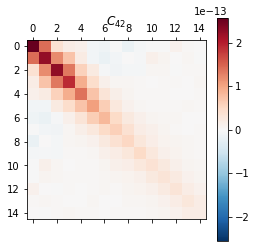

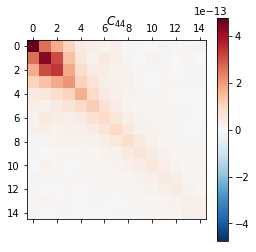

In [63]:
collapsed_mat = collapse_axes(tot_mat,5,2)
for i in range(3):
    for j in range(3):
        vmax=np.percentile(collapsed_mat[i,j],99.9)
        plt.matshow(collapsed_mat[i,j],vmax=vmax,vmin=-vmax,cmap=cm.RdBu_r);
        plt.title(r'$C_{%d%d}$'%(2*i,2*j))
        plt.colorbar();